# Modern Data Lake Storage Layers - Apache Iceberg

In [ ]:
%%configure -f
{
    "conf": {
        "spark.jars": "hdfs:///apps/iceberg/lib/iceberg-spark3-runtime.jar",
        "spark.sql.extensions":"org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions",
        "spark.sql.catalog.spark_catalog":"org.apache.iceberg.spark.SparkCatalog"
    }
}

In [ ]:
%env S3_BUCKET_NAME=YOUR_S3_BUCKET_NAME

In [ ]:
S3_BUCKET_NAME="YOUR_S3_BUCKET_NAME"
ICEBERG_TABLE_NAME="iceberg_demo_001"

## The basics of Apache Iceberg

Let's use the same approach we used in the Hudi notebook. Note that Iceberg uses a table format so in addition to writing the data to S3, we also need to save it as a table. We'll see what impact that has later.

_One important thing to note:_ Typically in Spark `overwrite` mode, the data on S3 gets replaced. However, because we're using a different format (`iceberg`) *and* because Iceberg uses manifest files instead of directory lists, data on S3 is not removed. If you run this notebook multiple times, you'll see additional files show up.

In [4]:
# Create a DataFrame
inputDF = spark.createDataFrame(
    [
        ("100", "2015-01-01", "2015-01-01T13:51:39.340396Z"),
        ("101", "2015-01-01", "2015-01-01T12:14:58.597216Z"),
        ("102", "2015-01-01", "2015-01-01T13:51:40.417052Z"),
        ("103", "2015-01-01", "2015-01-01T13:51:40.519832Z"),
        ("104", "2015-01-02", "2015-01-01T12:15:00.512679Z"),
        ("105", "2015-01-02", "2015-01-01T13:51:42.248818Z"),
    ],
    ["id", "creation_date", "last_update_time"],
)

# Write a DataFrame as an Iceberg dataset
inputDF.write.format("iceberg").mode("overwrite").partitionBy("creation_date").option(
    "path", f"s3://{S3_BUCKET_NAME}/tmp/iceberg/"
).saveAsTable(ICEBERG_TABLE_NAME)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's take a look in S3.

In [5]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/

                           PRE data/
                           PRE metadata/


In [6]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/data/

                           PRE creation_date=2015-01-01/
                           PRE creation_date=2015-01-02/


In [7]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/metadata/

2022-02-01 19:39:12       2517 00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json
2022-02-01 19:39:11       6376 599fc94a-4523-445c-bad0-bd5e2e9e6da1-m0.avro
2022-02-01 19:39:11       3802 snap-5655796012145429443-1-599fc94a-4523-445c-bad0-bd5e2e9e6da1.avro


OK, so we can see here we've got two folders in the main `iceberg` folder. Inside the `data` folder we see our two partitions and then we see quite a bit of files in the `metadata` folder including JSON files and some `.avro` files. Let's take a look at everything in S3.

In [8]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/ --recursive | tee /tmp/iceberg_op_001

2022-02-01 19:39:09       1171 tmp/iceberg/data/creation_date=2015-01-01/00002-2-8f202dd6-3220-4e54-8185-5d3c8e5ef4c6-00001.parquet
2022-02-01 19:39:09       1171 tmp/iceberg/data/creation_date=2015-01-01/00005-5-78bb818c-b281-452e-abda-1ebea5216409-00001.parquet
2022-02-01 19:39:09       1171 tmp/iceberg/data/creation_date=2015-01-01/00007-7-4e5be03d-9b05-4e7f-801c-4a7034f9e2aa-00001.parquet
2022-02-01 19:39:09       1171 tmp/iceberg/data/creation_date=2015-01-01/00010-10-e65537ad-f17a-45d3-9ec0-9a9a1eeeb0c4-00001.parquet
2022-02-01 19:39:09       1172 tmp/iceberg/data/creation_date=2015-01-02/00013-13-658258b9-d5ec-4834-8e17-168baed72b07-00001.parquet
2022-02-01 19:39:09       1172 tmp/iceberg/data/creation_date=2015-01-02/00015-15-62cf174f-1fff-4c5f-a0d7-8170e6722346-00001.parquet
2022-02-01 19:39:12       2517 tmp/iceberg/metadata/00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json
2022-02-01 19:39:11       6376 tmp/iceberg/metadata/599fc94a-4523-445c-bad0-bd5e2e9e6da1-m0.avro

One learning I had while setting this up is that there is a new `DataFrameWriterV2` API for writing to tables using data frames. 

Attempting to use the v1 DataFrame write API resulted in unexpected behavior, partially due to the fact that we also use `saveAsTable`.

So whereas with Hudi, all data and metadata is stored in S3, with the default implementation in Iceberg there is both the data on S3 as well as the metadata in the data catalog. Let's see if we can take a look at that...in order to do this, we just take the most recent `metadata.json` file from S3 and read that - we unfortunately can't see the raw Hive data catalog from Spark because we are using the Iceberg SparkSession wrapper.

In [9]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/metadata/ | grep metadata.json | sort | tail -n 1 | tr -s " " | cut -d\  -f4

00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json


In [10]:
df = spark.read.json(f"s3://{S3_BUCKET_NAME}/tmp/iceberg/metadata/*.metadata.json", multiLine=True)

recordDF = df.sort(df["last-updated-ms"].desc()).limit(1)
recordJSON = recordDF.toJSON().collect()[0]

import json
print(json.dumps(json.loads(recordJSON.replace(S3_BUCKET_NAME, '<BUCKET>')), indent=4, sort_keys=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{
    "current-schema-id": 0,
    "current-snapshot-id": 5655796012145429443,
    "default-sort-order-id": 0,
    "default-spec-id": 0,
    "format-version": 1,
    "last-column-id": 3,
    "last-partition-id": 1000,
    "last-updated-ms": 1643744351172,
    "location": "s3://<BUCKET>/tmp/iceberg/",
    "metadata-log": [],
    "partition-spec": [
        {
            "field-id": 1000,
            "name": "creation_date",
            "source-id": 2,
            "transform": "identity"
        }
    ],
    "partition-specs": [
        {
            "fields": [
                {
                    "field-id": 1000,
                    "name": "creation_date",
                    "source-id": 2,
                    "transform": "identity"
                }
            ],
            "spec-id": 0
        }
    ],
    "properties": {
        "owner": "livy"
    },
    "schema": {
        "fields": [
            {
                "id": 1,
                "name": "id",
                "requi

OK, so there is a *lot* of data in here. Let's pick out just a few things:

- `location` - This is the location of the data files on S3.
- `schemas` - Shows different schemas for this table - Iceberg supports [schema evolution](https://iceberg.apache.org/#evolution#schema-evolution).
- `snapshots` - This is a list of data files that make up the table's contents at the time of the snapshot. It includes a `manifest-list` that is a single file that stores the manifests that make up table snapshot. Those manifests list a subset of the data files themselves.

Keep in mind that one of the motivators for Iceberg was the ability to manage huge (petabyte-scale) tables in cloud object stores. Partition management, schema evolution, and consistency/atomicity are all challenges at scale and this manifest approach is a core part of the design to address those challenges

The [Iceberg spec](https://iceberg.apache.org/#spec) has a great image that illustrates this:

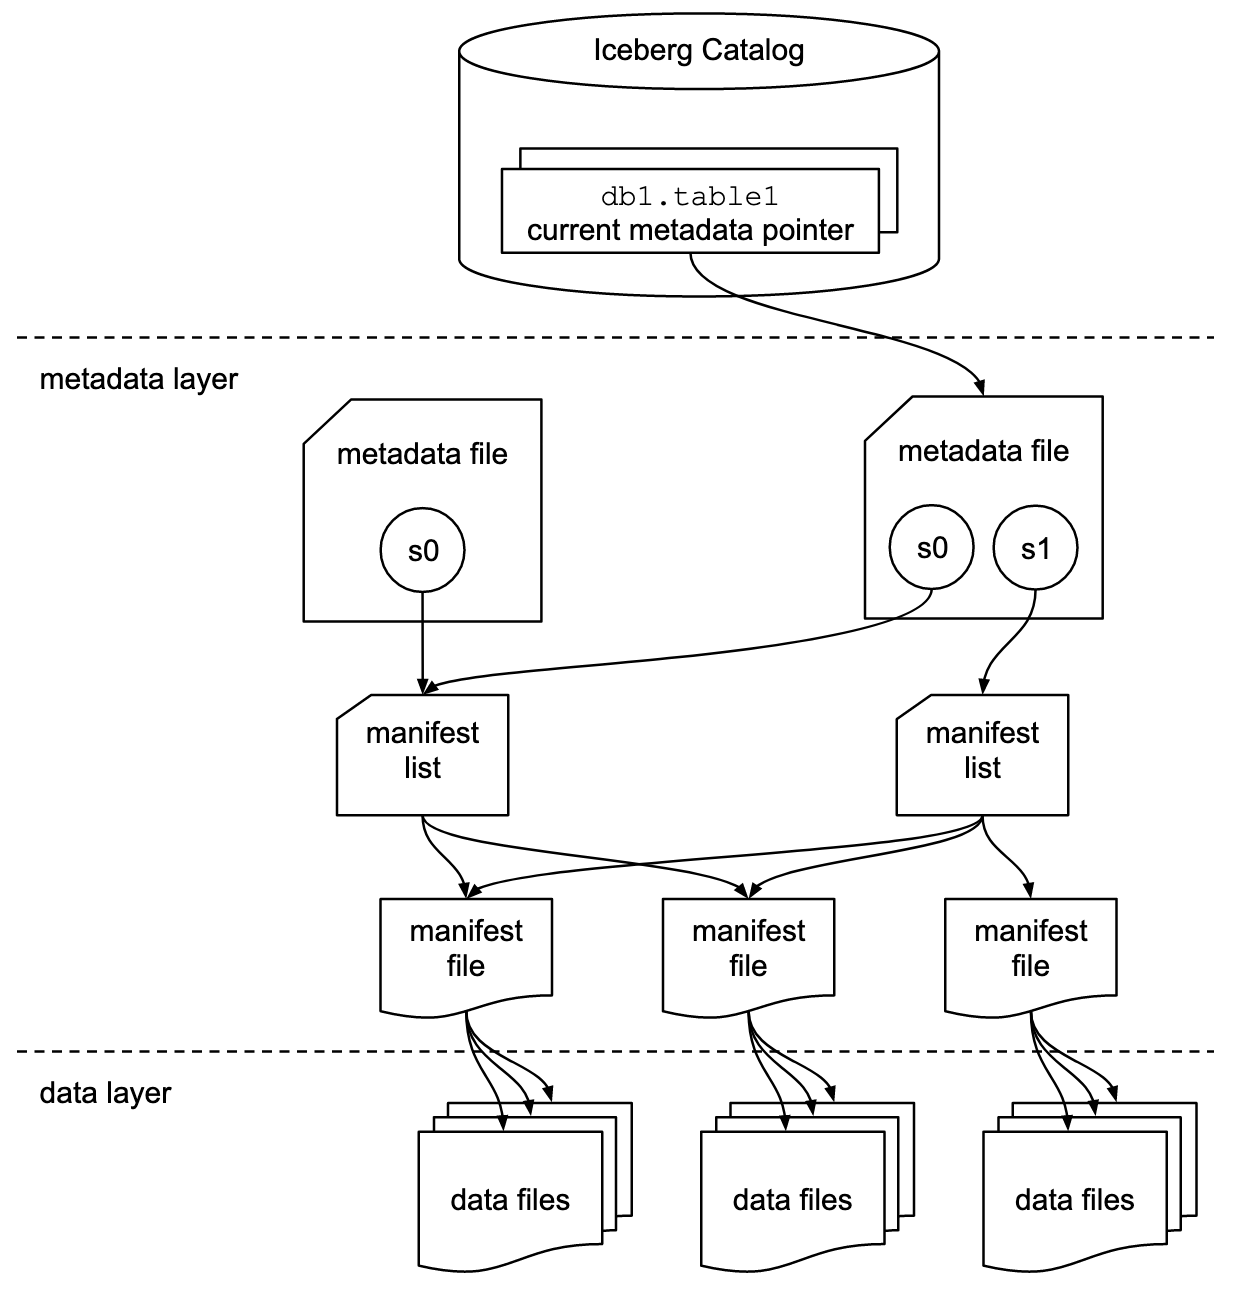

Let's also see if we can peak into that `avro` manifest list file.

In [11]:
from pyspark.sql.functions import regexp_replace


manifest_list_file = recordDF.collect()[0].asDict().get('snapshots')[0]['manifest-list']

mfListDF = spark.read.format("avro").load(manifest_list_file)
mfListDF.withColumn("manifest_path", regexp_replace('manifest_path', S3_BUCKET_NAME, '<BUCKET>')).show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------------------+---------------+-----------------+-------------------+----------------------+-------------------------+------------------------+----------------------------------------+----------------+-------------------+------------------+
|manifest_path                                                                  |manifest_length|partition_spec_id|added_snapshot_id  |added_data_files_count|existing_data_files_count|deleted_data_files_count|partitions                              |added_rows_count|existing_rows_count|deleted_rows_count|
+-------------------------------------------------------------------------------+---------------+-----------------+-------------------+----------------------+-------------------------+------------------------+----------------------------------------+----------------+-------------------+------------------+
|s3://<BUCKET>/tmp/iceberg/metadata/599fc94a-4523-445c-bad0-bd5e2e9e6da1-m0.avr

Interesting - so this manifest list file gives us different `manifest_path`s and information about them including rows added/deleted and partitions in the file. This is starting to make sense because one can now see how Iceberg would query the `manifest-list` file to filter down the location of manifests based on things like partitions. And if you have 10s of thousands of partitions...being able to filter ahead of time as opposed to list keys in your cloud storage is much more efficient.

Let's also take a quick peek inside an actual manifest file.

In [12]:
import pyspark.sql.functions as f


manifest_path = mfListDF.limit(1).collect()[0].manifest_path

mfDF = spark.read.format("avro").load(manifest_path)
mfDF.withColumn("data_file", f.col("data_file").withField("file_path", regexp_replace('data_file.file_path', S3_BUCKET_NAME, '<BUCKET>'))).show(truncate=False)

mfDF.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|status|snapshot_id        |data_file                                                                                                                                                                                                                                                                                                                                                                 |
+------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In addition to the actual data, it's helpful to look at the schema here as well. We can see that there is *so* much data in the manifest file including information about record counts, upper/lower bounds, and partitions.

## Updating Data

Ok, now that we have a good understanding of how data is written initially - let's see what happens when we update a record.

While I tried, I wasn't able to figure out how to do this with native Spark DataFrames so ended up using Spark SQL instead. This is also partially because I'm updating the partition field - if you were updating a different attribute, I think it might work.

In [13]:
from pyspark.sql.functions import lit

# Create a new DataFrame from the first row of inputDF with a different creation_date value
updateDF = inputDF.where("id = 100").withColumn("creation_date", lit("2022-01-11"))
updateDF.show()

# Leaving my attempt at overwriting with the dataframe here for posterity
# updateDF.write.format("iceberg").mode("overwrite").option("overwrite-mode", "dynamic").partitionBy("creation_date").save(ICEBERG_TABLE_NAME)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2022-01-11|2015-01-01T13:51:...|
+---+-------------+--------------------+

In [14]:
spark.sql(f"UPDATE {ICEBERG_TABLE_NAME} SET creation_date = '2022-01-11' WHERE id = 100")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

First, we'll look at S3 again.

In [15]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/ --recursive > /tmp/iceberg_op_002
diff -u /tmp/iceberg_op_001 /tmp/iceberg_op_002 || true

--- /tmp/iceberg_op_001	2022-02-01 19:42:29.254692361 +0000
+++ /tmp/iceberg_op_002	2022-02-01 19:49:28.022200062 +0000
@@ -4,6 +4,11 @@
 2022-02-01 19:39:09       1171 tmp/iceberg/data/creation_date=2015-01-01/00010-10-e65537ad-f17a-45d3-9ec0-9a9a1eeeb0c4-00001.parquet
 2022-02-01 19:39:09       1172 tmp/iceberg/data/creation_date=2015-01-02/00013-13-658258b9-d5ec-4834-8e17-168baed72b07-00001.parquet
 2022-02-01 19:39:09       1172 tmp/iceberg/data/creation_date=2015-01-02/00015-15-62cf174f-1fff-4c5f-a0d7-8170e6722346-00001.parquet
+2022-02-01 19:49:24       1171 tmp/iceberg/data/creation_date=2022-01-11/00000-40-ea399986-587e-41d8-ab4c-89c69f2a3112-00001.parquet
 2022-02-01 19:39:12       2517 tmp/iceberg/metadata/00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json
+2022-02-01 19:49:24       3696 tmp/iceberg/metadata/00001-ea6c6f52-3dca-4aea-a0f0-c941b3d499b6.metadata.json
 2022-02-01 19:39:11       6376 tmp/iceberg/metadata/599fc94a-4523-445c-bad0-bd5e2e9e6da1-m0.avro
+2022-02-

We can see that we have:
- 2 new `.parquet` data files
- 1 new `metadata.json` file
- 2 new `.avro` manifest files
- 1 new `snap-*.avro` manifest list

Let's take a look at the metadata and manifest files again.

In [16]:
df = spark.read.json(f"s3://{S3_BUCKET_NAME}/tmp/iceberg/metadata/*.metadata.json", multiLine=True)
recordDF = df.sort(df["last-updated-ms"].desc()).limit(1)
recordJSON = recordDF.toJSON().collect()[0]
import json
print(json.dumps(json.loads(recordJSON.replace(S3_BUCKET_NAME, '<BUCKET>')), indent=4, sort_keys=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{
    "current-schema-id": 0,
    "current-snapshot-id": 5884609264843258274,
    "default-sort-order-id": 0,
    "default-spec-id": 0,
    "format-version": 1,
    "last-column-id": 3,
    "last-partition-id": 1000,
    "last-updated-ms": 1643744963721,
    "location": "s3://<BUCKET>/tmp/iceberg/",
    "metadata-log": [
        {
            "metadata-file": "s3://<BUCKET>/tmp/iceberg/metadata/00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json",
            "timestamp-ms": 1643744351172
        }
    ],
    "partition-spec": [
        {
            "field-id": 1000,
            "name": "creation_date",
            "source-id": 2,
            "transform": "identity"
        }
    ],
    "partition-specs": [
        {
            "fields": [
                {
                    "field-id": 1000,
                    "name": "creation_date",
                    "source-id": 2,
                    "transform": "identity"
                }
            ],
            "spec-id": 0
    

We now have an additional "snapshot" with a new `manifest-list`. It even tells us that this snapshot had 1 `added-data-files` and 1 `added-records`, _as well as_ **2** `changed-partition-count` and 1 `deleted-records`!

In [17]:
from pyspark.sql.functions import regexp_replace


manifest_list_file = recordDF.collect()[0].asDict().get('snapshots')[-1]['manifest-list']

mfListDF = spark.read.format("avro").load(manifest_list_file)
mfListDF.withColumn("manifest_path", regexp_replace('manifest_path', S3_BUCKET_NAME, '<BUCKET>')).show(truncate=False)



manifest_path = mfListDF.limit(1).collect()[0].manifest_path
mfDF = spark.read.format("avro").load(manifest_path)
mfDF.withColumn("data_file", f.col("data_file").withField("file_path", regexp_replace('data_file.file_path', S3_BUCKET_NAME, '<BUCKET>'))).show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------------------------------------------------------------+---------------+-----------------+-------------------+----------------------+-------------------------+------------------------+----------------------------------------+----------------+-------------------+------------------+
|manifest_path                                                                  |manifest_length|partition_spec_id|added_snapshot_id  |added_data_files_count|existing_data_files_count|deleted_data_files_count|partitions                              |added_rows_count|existing_rows_count|deleted_rows_count|
+-------------------------------------------------------------------------------+---------------+-----------------+-------------------+----------------------+-------------------------+------------------------+----------------------------------------+----------------+-------------------+------------------+
|s3://<BUCKET>/tmp/iceberg/metadata/fd493887-b82b-4529-bd20-150805540362-m1.avr

So we can see that our `manifest-list` file now has 2 manifests in it. And if we read the most recent manifest, we can see that it points to the one additional `.parquet` file in our new `2022-01-11` partition. Now...let's make sure the data looks good!

In [18]:
df = spark.table(ICEBERG_TABLE_NAME)
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
|100|   2022-01-11|2015-01-01T13:51:...|
+---+-------------+--------------------+

Awesome! It looks good.

_Note:_ On the first go through of this, I couldn't figure out how to do the update with native Spark DataFrames so changed to Spark SQL. :)

## Deleting Data

Now, let's look into deletes. Again, we'll use Spark SQL to do this.

In [19]:
spark.sql(f"DELETE FROM {ICEBERG_TABLE_NAME} WHERE id=100")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[]

Back to S3.

In [20]:
%%sh

aws s3 ls s3://${S3_BUCKET_NAME}/tmp/iceberg/ --recursive > /tmp/iceberg_op_003
diff -u /tmp/iceberg_op_002 /tmp/iceberg_op_003 || true

--- /tmp/iceberg_op_002	2022-02-01 19:49:28.022200062 +0000
+++ /tmp/iceberg_op_003	2022-02-01 19:54:06.385890327 +0000
@@ -7,8 +7,11 @@
 2022-02-01 19:49:24       1171 tmp/iceberg/data/creation_date=2022-01-11/00000-40-ea399986-587e-41d8-ab4c-89c69f2a3112-00001.parquet
 2022-02-01 19:39:12       2517 tmp/iceberg/metadata/00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json
 2022-02-01 19:49:24       3696 tmp/iceberg/metadata/00001-ea6c6f52-3dca-4aea-a0f0-c941b3d499b6.metadata.json
+2022-02-01 19:54:04       4780 tmp/iceberg/metadata/00002-3cb69aaf-bd5b-4f9c-95c8-102711e72717.metadata.json
 2022-02-01 19:39:11       6376 tmp/iceberg/metadata/599fc94a-4523-445c-bad0-bd5e2e9e6da1-m0.avro
+2022-02-01 19:54:04       6166 tmp/iceberg/metadata/d8e0968a-25d1-4d67-ac85-daddef0a050d-m0.avro
 2022-02-01 19:49:24       6396 tmp/iceberg/metadata/fd493887-b82b-4529-bd20-150805540362-m0.avro
 2022-02-01 19:49:24       6164 tmp/iceberg/metadata/fd493887-b82b-4529-bd20-150805540362-m1.avro
 2022-0

One new file each of a `metadata.json`, `.avro` manifest, and `snap-*.avro` manifest list.

We'll look at the data table to ensure the delete worked and then the new metadata.

In [21]:
spark.sql(f"SELECT * FROM {ICEBERG_TABLE_NAME}").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+

In [22]:
df = spark.read.json(f"s3://{S3_BUCKET_NAME}/tmp/iceberg/metadata/*.metadata.json", multiLine=True)
recordDF = df.sort(df["last-updated-ms"].desc()).limit(1)
recordJSON = recordDF.toJSON().collect()[0]
import json
print(json.dumps(json.loads(recordJSON.replace(S3_BUCKET_NAME, '<BUCKET>')), indent=4, sort_keys=True))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{
    "current-schema-id": 0,
    "current-snapshot-id": 7202682147828423470,
    "default-sort-order-id": 0,
    "default-spec-id": 0,
    "format-version": 1,
    "last-column-id": 3,
    "last-partition-id": 1000,
    "last-updated-ms": 1643745243221,
    "location": "s3://<BUCKET>/tmp/iceberg/",
    "metadata-log": [
        {
            "metadata-file": "s3://<BUCKET>/tmp/iceberg/metadata/00000-7bf31f4a-f1c6-40d4-beaf-cc9a2620fe3b.metadata.json",
            "timestamp-ms": 1643744351172
        },
        {
            "metadata-file": "s3://<BUCKET>/tmp/iceberg/metadata/00001-ea6c6f52-3dca-4aea-a0f0-c941b3d499b6.metadata.json",
            "timestamp-ms": 1643744963721
        }
    ],
    "partition-spec": [
        {
            "field-id": 1000,
            "name": "creation_date",
            "source-id": 2,
            "transform": "identity"
        }
    ],
    "partition-specs": [
        {
            "fields": [
                {
                    "field-id": 1000,


## Snapshots

Iceberg also supports "point-in-time" queries, called time travel. You can supply a `snapshot-id` or `as-of-timestamp`.

In [34]:
# Pull out the first metadata snapshot timestamp and snapshot-id
df = spark.read.json(f"s3://{S3_BUCKET_NAME}/tmp/iceberg/metadata/*.metadata.json", multiLine=True)
firstSnapshot = df.sort(df["last-updated-ms"].asc()).limit(1).collect()[0]
earliest_timestamp = firstSnapshot['last-updated-ms']
earliest_snapshot_id = firstSnapshot['current-snapshot-id']

# Now read the data from that point in time
df = spark.read \
    .option("as-of-timestamp", earliest_timestamp) \
    .format("iceberg") \
    .load(ICEBERG_TABLE_NAME)
    
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2015-01-01|2015-01-01T13:51:...|
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+

In [35]:
# time travel to the first snapshot
df = spark.read \
    .option("snapshot-id", earliest_snapshot_id) \
    .format("iceberg") \
    .load(ICEBERG_TABLE_NAME)
    
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-------------+--------------------+
| id|creation_date|    last_update_time|
+---+-------------+--------------------+
|100|   2015-01-01|2015-01-01T13:51:...|
|101|   2015-01-01|2015-01-01T12:14:...|
|102|   2015-01-01|2015-01-01T13:51:...|
|103|   2015-01-01|2015-01-01T13:51:...|
|104|   2015-01-02|2015-01-01T12:15:...|
|105|   2015-01-02|2015-01-01T13:51:...|
+---+-------------+--------------------+

## Cleanup

This is a utility section for different commands needed while building this notebook. Destructive commands are bracketed with a "default false" condition so they don't execute in the course of normal execution.

- Clear Iceberg Tables - Clears any tables in the Spark catalog that start with `iceberg_demo_` (**must** be run before removing files from S3)

In [ ]:
if 1 == 2:
    iceberg_tables = [table.name for table in spark.catalog.listTables() if table.name.startswith("iceberg_demo")]
    for table_name in iceberg_tables:
        print(f"Dropping {table_name}")
        spark.sql(f"DROP TABLE IF EXISTS {table_name}")


- Clear S3 - Iceberg "overwrite" does not delete existing tables, so we need to do it ourselves

In [ ]:
%%sh

if [ 1 == 2 ]; then
    aws s3 rm --recursive s3://${S3_BUCKET_NAME}/tmp/iceberg/
fi